In [1]:
import sys
sys.path.append("../scripts/")
from gridmap import *
from matplotlib.animation import PillowWriter    #アニメーション保存用
import math
import random
import copy

In [2]:
class RRT():
    def __init__(self, grid_map_world, ratioPointGoal=0.9, drawVertex=False):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.vertex = np.empty((0, 3), float)    #[x, y, cost]
        self.edge = []  #[id1, id2]
        self.candidate = []
        self.parent = []    #[x, y]
        self.id = np.empty((0, 2), float)    #[x, y]
        self.isStart = True
        self.isFinish = False
        self.isPathDraw = False
        self.ratePointGoal = ratioPointGoal
        self.marker_size = 4
        self.start_cordinate = (self.world.start_index + 1/2) * self.world.grid_step
        self.goal_cordinate = (self.world.goal_index + 1/2) * self.world.grid_step
        self.drawVertexflag = drawVertex
    
    def draw(self, ax, elems):
        xs, xn, xp = self.RRT()
        
        self.drawEdge(ax, elems)    #全エッジを描画
        if(self.drawVertexflag):
            self.drawVertex(ax, elems)    #全頂点を描画
        if(not(self.isFinish)):
            self.drawSamplingPoint(ax, elems, xs)    #サンプリング点を描画
            self.drawExtendedEdge(ax, elems, xn, xp)    #拡張したエッジを描画
        self.drawPath(ax, elems)    #得られた経路の描画
    
    def RRT(self):
        if(self.isFinish):
            return None, None, None
        if(self.isStart):
            x, y = self.start_cordinate
            self.vertex = np.vstack([self.vertex, [x, y, 0.0]])
            self.parent.append(0)
            self.isStart = False
            self.id = np.vstack([self.id, [x, y]])
        xn, xp, xp_n = None, None, None
        cost_n = None
        nearest_id = None
        isFindVertex = False
        while(isFindVertex == False):    #結べる点が得られるまで繰り返す
            #サンプリング
            if(random.random() > self.ratePointGoal and not(self.isFinish)):
                xp = self.goal_cordinate    #ある確率でゴールを選択する
            else:
                xp = self.world.grid_num * self.world.grid_step * np.array([random.random(), random.random()])
                xp = self.returnGoalGrid(xp)
            
            candidate = self.vertex
            #新しい点を探し，衝突確認を行う
            while(1):
                xn, xp_n, cost_n, nearest_id = self.getNearestVertex(xp, candidate)    #[xp, yp]に最も近い頂点を探索
                if self.isPoseInGoal(xn):
                    xn = self.goal_cordinate
                    isFindVertex = True
                    self.isFinish = True
                    break
                #隣接ノードと半径1.1 grid_step以内であれば除外する
                #障害物に当たったりマップ外に出たりした場合はxn=xp_n, yn=yp_n
                if(np.linalg.norm(xn - xp_n) < 0.001*np.linalg.norm(self.world.grid_step)):
                    candidate = np.delete(candidate, nearest_id, 0)
                    if(candidate == []):
                        break
                else:
                    isFindVertex = True
                    break
        
        cost_new = cost_n + np.linalg.norm(xn - xp_n)
        self.vertex = np.vstack([self.vertex,  [xn[0], xn[1], cost_new]])
        self.edge.append([xn[0], xn[1], xp_n[0], xp_n[1]])
        self.parent.append(xp_n)
        self.id = np.vstack([self.id, xn])
        return xp, xn, xp_n    #サンプリング点，新しい点，ペアレント点を返す
    
    #最も近い頂点を探し，2つの頂点の座標とコストを返す
    def getNearestVertex(self, xNew, candidates):
        dis = float('inf')
        dis_collision = float('inf')
        xNearest = []
        xNearest_collision = []
        cost_n = 0
        nearest_id = 0
        nearest_id_collision = 0
        for candidate in candidates:
            x, c = candidate[0:2], candidate[2]
            collision = 1
            #collision, _, _ = self.collisionFree(x, xNew, type2=False)
            if(collision == 1):
                if(dis > np.linalg.norm(xNew - x) and np.any(xNew != x)):
                    dis = np.linalg.norm(xNew - x)
                    xNearest = x
                    cost_n = c
                    nearest_id = np.where(np.all(candidates==candidate, axis=1))[0][0]
            elif(collision == 0):
                if(dis_collision > np.linalg.norm(xNew - x) and np.any(xNew != x)):
                    dis_collision = np.linalg.norm(xNew - x)
                    xNearest_collision = x
                    nearest_id_collision = np.where(np.all(candidates==candidate, axis=1))[0][0]
                    
        if(xNearest == []):
            xNearest = xNearest_collision
            nearest_id = nearest_id_collision
        
        isCollision, xCollision = self.collisionFree(xNearest, xNew, type2=True)
        if(isCollision == 0):
            return xNearest, xNearest, cost_n, nearest_id
        elif(isCollision == 2):
            return xCollision, xNearest, cost_n, nearest_id
        else:
            return xNew, xNearest, cost_n, nearest_id
    
    #x1, x2の間が障害物で挟まれていないか
    def collisionFree(self, x1, x2, type2=True):
        d = x2 - x1
        dr = np.linalg.norm(x2 - x1)
        x_next = x1
        
        while(np.linalg.norm(x_next - x1) < np.linalg.norm(x1 - x2)): #x1から少しずつ伸ばし，障害物があるか確認する
            x_next = x_next + self.world.grid_step * 0.01 * d / dr
            if(self.isPoseInObstacle(x_next)): #障害物に挟まれている場合
                return 0, x1
            if(
                type2 and
                (self.isPoseInGoal(x_next) and not(self.isPoseInGoal(x1)) and not(self.isPoseInGoal(x2)))
            ):
                return 1, self.goal_cordinate
            if(
                type2 and
                np.linalg.norm(x_next - x1) > 2 * np.linalg.norm(self.world.grid_step)
            ): #障害物に挟まれていないが，一定距離で制限しその点を返す
                return 2, x_next
        return 1, x2    #直接結んでも障害物に挟まれていない
    
    def returnGoalGrid(self, x): #ゴールのグリッドの中ならゴールの座標を返す
        if self.isPoseInGoal(x):
            return (self.world.goal_index + 0.5) * self.world.grid_step
        elif self.isPoseInOutOfBounds(x):
            return np.array([0.0, 0.0])
        else:
            return x
    
    def get_id(self, x): #id取得
        idx = np.where(np.all(self.id==x, axis=1))[0][0]
        return idx
    
    def poseToIndex(self, pose):
        return (np.array(pose[0:2]) // self.world.grid_step).astype(np.int32)
    
    def isPoseInObstacle(self, pose):
        index = self.poseToIndex(pose)
        if self.world.isObstacle(index):
            return True
        else:
            return False
    
    def isPoseInGoal(self, pose):
        index = self.poseToIndex(pose)
        if self.world.isGoal(index):
            return True
        else:
            return False
    
    def isPoseInOutOfBounds(self, pose):
        index = self.poseToIndex(pose)
        if self.world.isOutOfBounds(index):
            return True
        else:
            return False
    
    def drawVertex(self, ax, elems):
        for x in self.vertex:
            elems += ax.plot(x[0], x[1], marker='.', markersize=self.marker_size, color="Blue")
    
    def drawEdge(self, ax, elems):
        for edge in self.edge:
            x1, y1, x2, y2 = edge
            elems += ax.plot([x1, x2], [y1, y2], color="cyan", alpha=1.0)
            
    def drawExtendedEdge(self, ax, elems, x1, x2):
        elems += ax.plot([x1[0], x2[0]], [x1[1], x2[1]], color="blue", alpha=0.5)
    
    def drawSamplingPoint(self, ax, elems, x):
        elems += ax.plot(x[0], x[1], marker='.', color="red")
    
    def drawPath(self, ax, elems):
        if(self.isFinish):
            #ゴールからスタート
            id = self.get_id(self.goal_cordinate)
            distance = 0
            while(id != 0):    #スタート（id=0）になるまで繰り返す
                x1, y1 = self.id[id]
                x2, y2 = self.parent[id]
                id = self.get_id([x2, y2])
                elems += ax.plot([x1, x2], [y1, y2], color="red")
                distance += math.sqrt((x1-x2)**2 + (y1-y2)**2)
            dis_str ="Distance = %.4f" % (distance)
            elems.append(
                ax.text(
                    self.world.grid_step[0]*self.world.grid_num[0]*0.6,
                    self.world.grid_step[1]*self.world.grid_num[1]*1.02,
                    dis_str,
                    fontsize=10
                )
            )

<IPython.core.display.Javascript object>


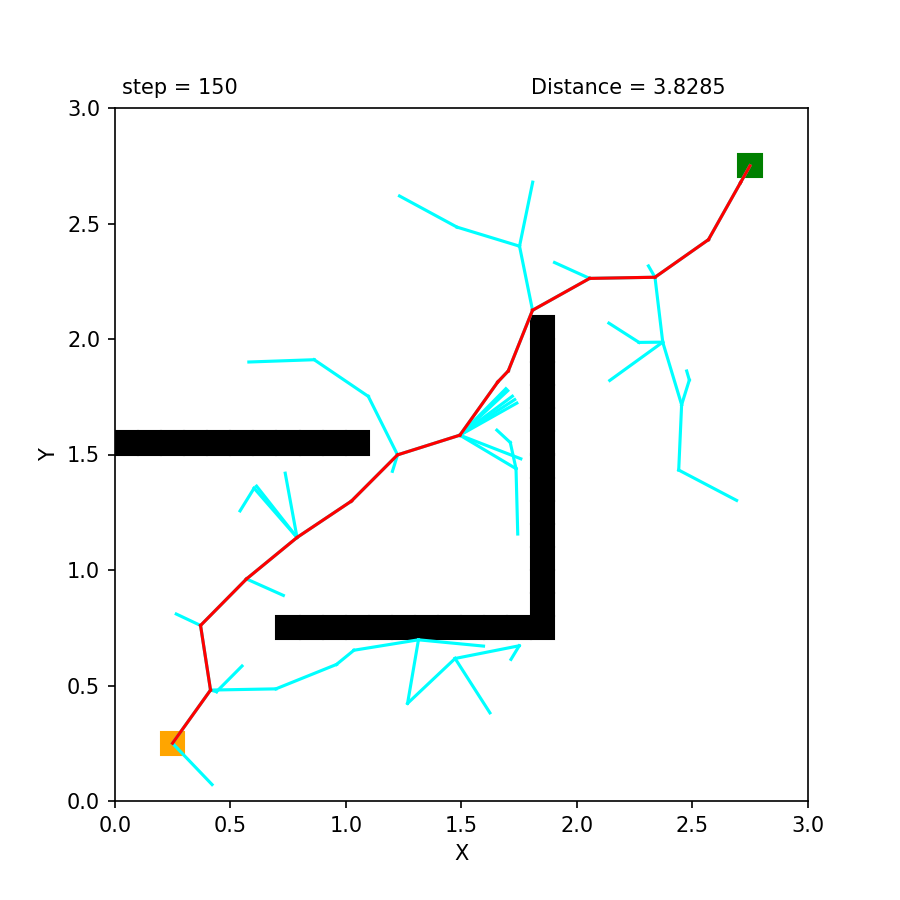

In [3]:
if __name__ == "__main__":
    time_span = 15
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map4.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(RRT(world, ratioPointGoal=0.95))
    
    world.draw()
    #world.ani.save('input.gif', writer='pillow', fps=100)    #アニメーション保存